# SHORT COMMUNICATION: FLOW AS DISTRIBUTED LINES WITHIN THE LANDSCAPE

### John J. Armitage

Dynamique des Fluides Géologiques, Institute de Physique du Globe de Paris, Paris, France


## Abstract

Landscape evolution models (LEMs) aim to capture an aggregation of the processes of erosion and deposition within the Earth's surface and predict the evolving topography. Over long time-scales, i.e. greater than one million years, the computational cost is such that numerical resolution is coarse and all small-scale properties of the transport of material cannot be captured. A key aspect therefore of such a long time-scale LEM is the algorithm chosen to route water down the surface. I explore the consequences of two end-member assumptions of how water flows over the surface of a LEM, either down a single flow direction (SFD) or down multiple flow directions (MFD), on model sediment flux and valley spacing. I find that by distributing flow along the edges of the mesh cells, node-to-node, the resolution dependence of the evolution of a LEM is significantly reduced. Furthermore, the flow paths of water predicted by this node-to-node MFD algorithm is significantly closer to that observed in nature. This reflects the observation that river channels are not necessarily fixed in space, and a distributive flow captures the sub-grid scale processes that create non-steady flow paths. Likewise, drainage divides are not fixed in time. By comparing results between the distributive transport-limited LEM and the stream power model "Divide And Capture", which was developed to capture the sub-grid migration of drainage divides, I find that in both cases the approximation for sub-grid scale processes leads to resolution independent valley spacing. I would therefore suggest that LEMs need to capture processes at a sub-grid scale to accurately model the earth's surface over long time-scales.

## Introduction

It is known that resolution impacts landscape evolution models (LEMs) ([Schoorl et al., 2000](#)). The resolution dependence of LEMs is caused by how run-off is routed down the model surface. It has been demonstrated that either distributing flow down all slopes (multiple flow direction, MFD), or simply allowing flow to descent down the steepest slope (single flow direction, SFD), gives different outcomes for landscape evolution models ([Schoorl et al., 2000](#), [Pelletier 2004](https://doi.org/10.1029/2004GL020802)). It has been noted that landscape potentially has a characteristic wavelength for the spacing of valleys ([Perron et al., 2008](https://doi.org/10.1029/2007JF000977)). Therefore, a landscape evolution model should be able to reproduce such regular topographic features independently of the model resolution. For a model of channelised flow it was however found that the routing of run-off led to a resolution dependence in the valley spacing, which could be overcome by the addition of a parameterised flow width that was less than the numerical grid spacing ([Perron et al., 2008](https://doi.org/10.1029/2007JF000977)).

There is a potential problem with parameterising the flow width to be fixed at a sub grid level. The response time of LEMs to a change in external forcing is strongly dependent of the surface run-off ([Armitage et al., 2018)](https://doi.org/10.5194/esurf-6-77-2018)). This means that the model response time becomes likewise dependent on the chosen flow width. Ideally the LEM would be independent of grid resolution without introducing a predefined length scale that impacts the model response.

Water is the primary agent of landscape erosion. There are multiple pathways within the hydrological cycle from evaporation, transpiration, and ground water flow, however for many landscapes the river network is the primary route through which water flows down slope. Mean river width varies from 5 km to a few meters ([Allen & Palvesky, 2018](https://doi.org/10.1126/science.aat0636)). The very wide rivers, greater than 1 km, are however outliers within this global data set, with the median of the distribution of mean river width being 124 m and the upper quartile at 432 m (Figure 1). In LEMs developed for understanding long-term landscape evolution the large time scales necessitate large spatial scales, where a single grid cell can be a kilometer wide or more ([Temme et al., 2017](https://doi.org/10.1002/esp.4162)). A spatial resolution of cells larger than a few meters becomes necessary when modelling at the scale of a continent (e.g. [Salles et al., 2017](https://doi.org/10.1002/2016GC006617)). This means that flow has a width at a subgrid level.

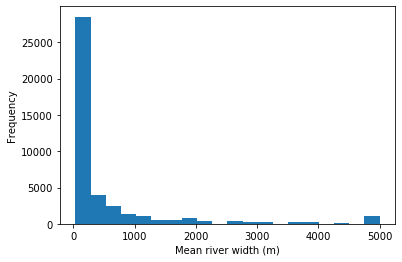

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

data = gpd.read_file('data/GRWL_summaryStats.shp')
fig = plt.figure()
ax = data['width_mean'].plot(kind='hist',bins=20)
ax.set_xlabel('Mean river width (m)')
plt.show()

**Figure 1**: *Distribution of mean river width taken from the Global River Widths from Landsat (GRWL) Database (Allen & Palvesky, 2018)*

If the width of the flow path for run-off is narrower than can be reasonably modelled, then can the flow paths be treated as lines, from model node-to-node (Figure 2), where water collects along these lines? To explore this idea and understand LEM sensitivity to resolution, I wish to explore how a simple LEM evolves under four scenarios (Figure 2): (1) simple single flow direction (SFD) from cell area to cell area, (2) a multiple flow direction (MFD) version of this cell-to-cell algorithm, (3) a node-to-node SFD, and (4) a node-to-node MFD.

## A landscape evolution model

In this study I will assume landscape evolution can be effectively simulated with the classic set of diffusive equations described in [Smith & Bretherton, 1972](https://doi.org/10.1029/WR008i006p01506):
\begin{equation}
\frac{\partial z}{\partial t} = \nabla \left[ \left(\kappa + c q_{w}^{n}\right) \nabla z \right] + U
\end{equation}
where $\kappa$ is a linear diffusion coefficient, $c$ is the fluvial diffusion coefficient, $q_{w}$ is the water flux, $n$ is the water flux exponent, and $U$ is uplift. This heuristic concentrative-diffusive equation is capable of generating realistic landscape morphology, with the slope-area relationships commonly observed ([Simpson & Schlunneger, 2003](https://doi.org/10.1029/2002JB002162), [Armitage et al., 2018](https://doi.org/10.5194/esurf-6-77-2018)). Strictly it assumes that there is always a layer of material to be transported by surface run-off, and as such it can be classed as a transport-limited model. It accounts for both erosion and deposition, and is therefore appropriate for modelling landscape evolution beyond mountain ranges and into the depositional setting (see models such as DIONISOS; [Granjeon & Joseph, 1999](#)). It differs from mixed erosion and deposition models such as [Kooi & Beaumont, 1994](#) and [Davy & Lague, 2009](https://doi.org/10.1029/2008JF001146) because those models split the divergence of the sediment flux into two terms, a rate of erosion and rate of deposition. Here instead I assume that the sediment flux is a function of water flux and slope.

Equation 1 is solved with a finite element scheme written using Python and the FEniCS libraries (I will call the code [fLEM](https://github.com/johnjarmitage/flem)). The equations are solved on a Delaunay mesh, where the mesh is made up of predominantly equilateral triangles with an opening angle of 60$^{\circ}$. Model boundary conditions are initially of fixed elevation on the sides normal to the x-axis and zero gradient on the sides in normal to the y-axis. The model aspect ratio is 4 to 1. Uplift is fixed at $U=10^{-4}\rm\,m\,yr^{-1}$, the linear diffusion coefficient is $\kappa = 1\rm\,m^{2}\,yr^{-1}$, the fluvial diffusion coefficient is $c=10^{-4}\rm\,(m^{2}\,yr^{-1})^{n-1}$, and the water flux exponent is $n=1.5$.

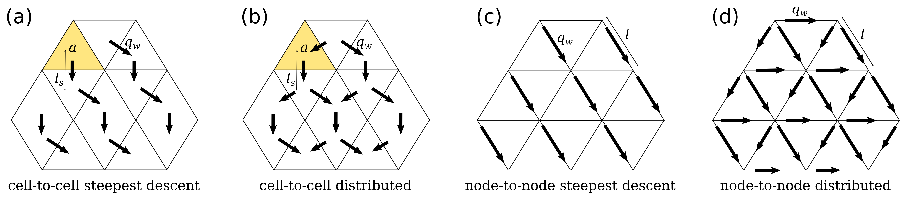

In [2]:
# markdown is not rendering images in voila...
import matplotlib.image as mpimg
img=mpimg.imread('figures/MFDandSFD.png')
plt.figure(figsize=(16, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

**Figure 2**: *Diagram of flow routing from cell-to-cell and node-to-node for either a single flow direction (SFD) and a multiple flow direction (MFD) algorithm weighted by the relative gradient.*

Water can be routed from cell-to-cell, where precipitation is collected over the area of each cell, sent downwards, and accumulates. In this cell-to-cell configuration the water flux has units of length squared per unit time and is given by:
\begin{equation}
q_{w}\mathrm{[cell]} = \frac{\alpha a}{l_{s}},
\end{equation}
where $\alpha$ is precipitation rate, $a$ is the cell area, and $l{s}$ is the length from cell center to cell center down the steepest slope (Figure 2a and b). This gives a water discharge per unit length, which has the advantage of not having to explicitly state the sub-grid width of the flow ([Simpson & Schlunneger, 2003](https://doi.org/10.1029/2002JB002162)). However, implicitly this implies that the flow is over the width of a cell. An alternative is to route water from node to node along cell edges and for it to accumulate. I assume that along the length of each cell edge water can be added to the flow line, assuming that the input is linearly related to the length of the flow line, 
\begin{equation}
q_{w}\mathrm{[node]} = \alpha l,
\end{equation}
where $l$ is the length of the edge that joins the up-slope node to the down-slope node (Figure 2c and d). This means that the cell area is ignored and instead water enters the flow path uniformly along its length and accumulates down slope.

Equation 3 makes the assumption that water accumulates as a function of length. Water flux is observed to related to catchment area, $Q_{w} \propto A^{0.8}$ ([Syvitski & Milliman, 2007](https://doi.org/10.1086/509246)). The catchment length, $l$ is then related to area by, $l\propto A^{1/p}$, where $1.4<p<2.0$ ([Armtiage et al., 2018)](https://doi.org/10.5194/esurf-6-77-2018)). At the lower end of the range this gives $Q_{w} \propto l^{1.12}$, suggesting that accumulating water as a linear function of flow length is a reasonable simplification. A knock on effect of this assumption is that the magnitude of the water flux predicted for the node-to-node routing is less than the cell-to-cell, as in the latter water is accumulated over cell areas, which is naturally larger than the cells edges.

Both equations 2 and 3 do not attempt to capture the interaction between water flux and river width, rather these are two methods to approximate run-off within a coarse numerical grid. For both the cell-to-cell and node-to-node methods the flow can then be routed down a single flow direction (SFD) or routed down multiple flow directions (MFD) weighted by the relative gradient, as in for example [Schoorl et al., 2000](#). I run the numerical model with a uniform precipitation rate of $\alpha = 1\rm\,m\,yr^{-1}$.

Equation 1 is made dimensionless following ([Simpson & Schlunneger, 2003](https://doi.org/10.1029/2002JB002162)) using the linear diffusion time scale and the model length in the $x$-direction, $L$. This means that equation 1 can be re-written as,
\begin{equation}
\frac{\partial \tilde{z}}{\partial \tilde{t}} = \nabla \left[ \left(1 + D \tilde{q}_{w}^{n}\right) \tilde{\nabla} \tilde{z} \right] + U
\end{equation}
and,
\begin{equation}
\tilde{\nabla} \cdot \left(\frac{\tilde{\nabla}\tilde{z}}{|\tilde{\nabla}\tilde{z}|}\right) \tilde{q}_{w} = -1
\end{equation}
where $x = \tilde{x}L$, $y = \tilde{y}L$, $z = \tilde{z}L$, $t = \tilde{t}L^{2}/\kappa$, $q = \tilde{q}\alpha L$, and,
\begin{equation}
D =  \frac{c\alpha^{n}L^{n}}{\kappa}.
\end{equation}


## The effect of model resolution

In [3]:
import os,sys
import pyvista as pv
from pyvista import set_plot_theme
set_plot_theme('document')
# flem is up the directory tree...
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from flem import initialise, solve_flem

In [4]:
# Domain dimensions
dem = 0
bounds = [0, 2e5, 0, 8e5]
res = 128
model_space, u_n, mesh, V, bc = initialise(dem, bounds, res)

In [5]:
# Physical parameters
physical_space = [1e+0,1e-4,1.5,1,1e-4] # [kappa, c, nexp, alpha, U]

# 0 = MFD node-to-node; 1 = MFD cell-to-cell; 2 = SD node-to-node; 3 = SD cell-to-cell
flow = 3

# Time
dt = 1e4
num_steps = 501

# Output
out_time = 100

# Plot stuff
plot = 0

# Calculate valley to valley wavelength
statistics = 1

In [6]:
name = 'SFDcelltocell'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)

In [7]:
#[sed_SDctc_128, time_SDctc_128, wav_SDctc_128] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [8]:
elevation = pv.read('SFDcelltocell/u_solution_128_500000000.vtu')
flux = pv.read('SFDcelltocell/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDcelltocell = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [9]:
# 0 = MFD node-to-node; 1 = MFD cell-to-cell; 2 = SD node-to-node; 3 = SD cell-to-cell
flow = 2
name = 'SFDnodetonode'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_SDntn_128, time_SDntn_128, wav_SDntn_128] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [10]:
elevation = pv.read('SFDnodetonode/u_solution_128_500000000.vtu')
flux = pv.read('SFDnodetonode/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDnodetonode = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [11]:
# 0 = MFD node-to-node; 1 = MFD cell-to-cell; 2 = SD node-to-node; 3 = SD cell-to-cell
flow = 1
name = 'MFDcelltocell'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_MFctc_128, time_MFctc_128, wav_MFctc_128] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [12]:
elevation = pv.read('MFDcelltocell/u_solution_128_500000000.vtu')
flux = pv.read('MFDcelltocell/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDcelltocell = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [13]:
# 0 = MFD node-to-node; 1 = MFD cell-to-cell; 2 = SD node-to-node; 3 = SD cell-to-cell
flow = 0
name = 'MFDnodetonode'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_MFntn_128, time_MFntn_128, wav_MFntn_128] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [14]:
elevation = pv.read('MFDnodetonode/u_solution_128_500000000.vtu')
flux = pv.read('MFDnodetonode/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDnodetonode = flux.warp_by_scalar(scalars='elevation',factor=5e2)

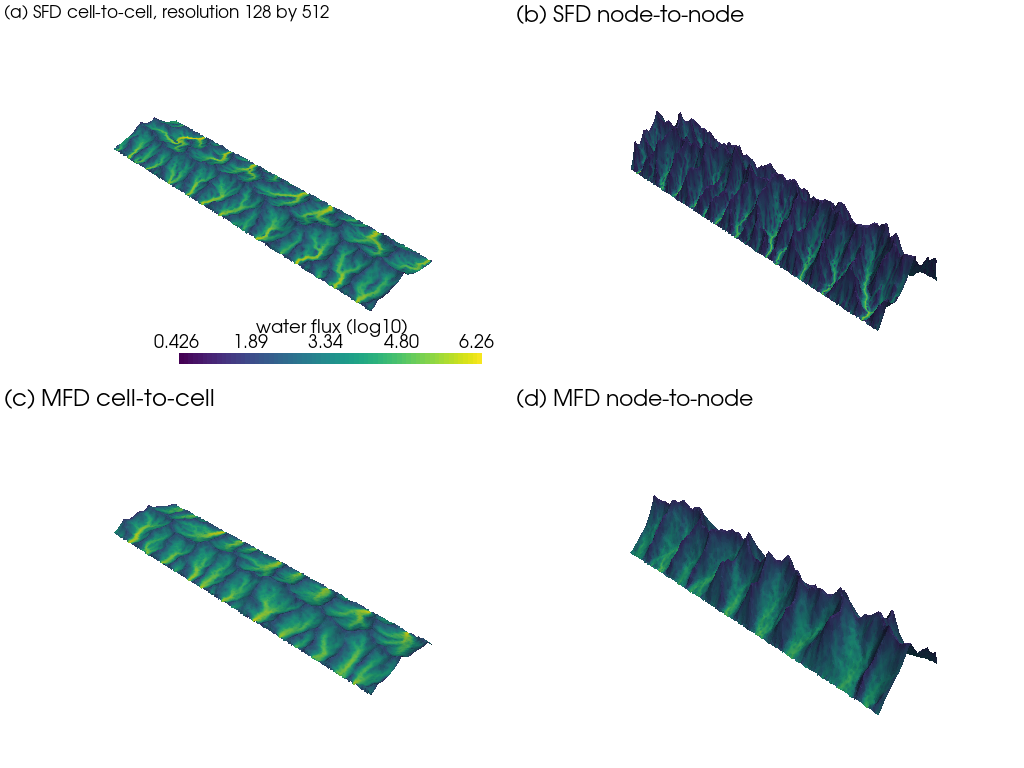

In [15]:
p = pv.Plotter(notebook=True, shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("(a) SFD cell-to-cell, resolution 128 by 512", font_size=12)
p.add_mesh(warpSFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(0, 1)
p.add_text("(b) SFD node-to-node", font_size=12)
p.add_mesh(warpSFDnodetonode, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 0)
p.add_text("(c) MFD cell-to-cell", font_size=12)
p.add_mesh(warpMFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 1)
p.add_text("(d) MFD node-to-node", font_size=12)
p.add_mesh(warpMFDnodetonode, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.show(use_panel=False)

**Figure 3**: *Shaded relief with colours showing the magnitude of surface run-off from the single (SFD) and multiple flow direction (MFD) routing using the cell-to-cell and node-to-node aproach. Model resolution is 128 by 512 nodes.*

In [16]:
from itkwidgets import view
view(geometries=warpMFDnodetonode)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

**Figure 4**: * Interactive plot of the multiple flow direction (MFD) node-to-node model for a resolution of 128 by 512 nodes.*

In [17]:
res=512
model_space, u_n, mesh, V, bc = initialise(dem, bounds, res)
flow = 3
name = 'SFDcelltocell'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_SDctc_512, time_SDctc_512, wav_SDctc_512] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [18]:
elevation = pv.read('SFDcelltocell/u_solution_512_500000000.vtu')
flux = pv.read('SFDcelltocell/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDcelltocell512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [19]:
res=512
flow = 2
name = 'SFDnodetonode'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_SDntn_512, time_SDntn_512, wav_SDntn_512] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [20]:
elevation = pv.read('SFDnodetonode/u_solution_512_500000000.vtu')
flux = pv.read('SFDnodetonode/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDnodetonode512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [21]:
res=512
flow = 1
name = 'MFDcelltocell'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_MFDctc_512, time_MFDctc_512, wav_MFDctc_512] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [22]:
elevation = pv.read('MFDcelltocell/u_solution_512_500000000.vtu')
flux = pv.read('MFDcelltocell/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDcelltocell512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [23]:
res=512
flow = 0
name = 'MFDnodetonode'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)
#[sed_MFntn_512, time_MFntn_512, wav_MFntn_512] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [24]:
elevation = pv.read('MFDnodetonode/u_solution_512_500000000.vtu')
flux = pv.read('MFDnodetonode/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDnodetonode512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

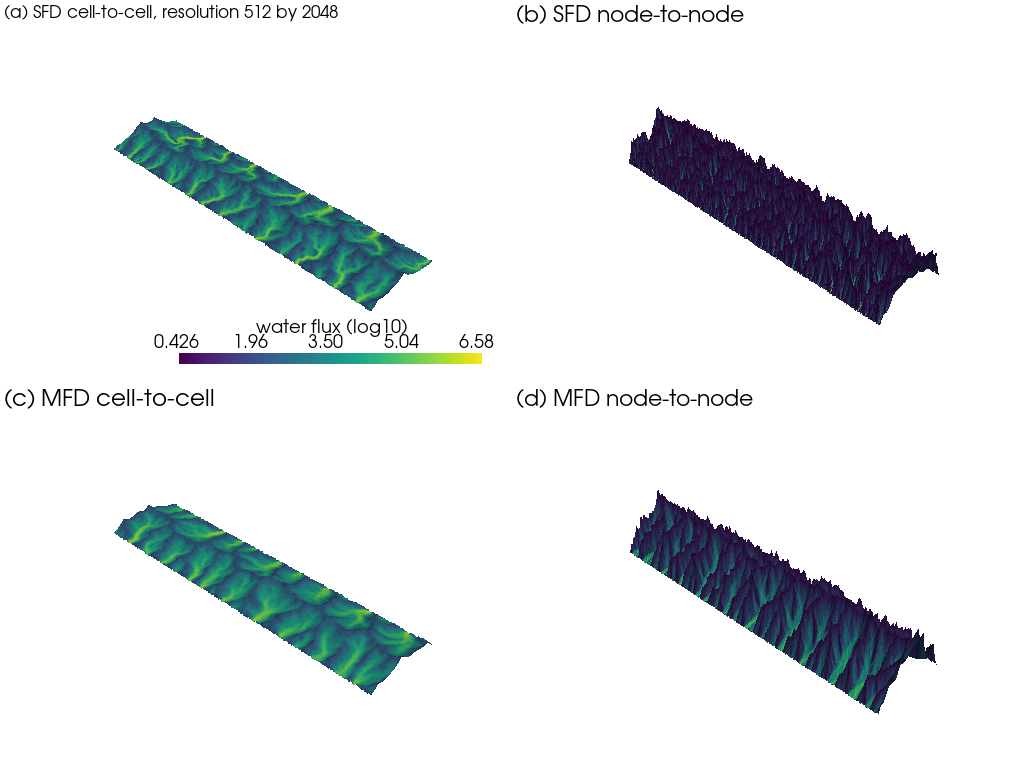

In [25]:
p = pv.Plotter(notebook=True, shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("(a) SFD cell-to-cell, resolution 512 by 2048", font_size=12)
p.add_mesh(warpSFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(0, 1)
p.add_text("(b) SFD node-to-node", font_size=12)
p.add_mesh(warpSFDnodetonode512, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 0)
p.add_text("(c) MFD cell-to-cell", font_size=12)
p.add_mesh(warpMFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 1)
p.add_text("(d) MFD node-to-node", font_size=12)
p.add_mesh(warpMFDnodetonode512, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.show(use_panel=False)

**Figure 5**: *Shaded relief with colours showing the magnitude of surface run-off from the single (SFD) and multiple flow direction (MFD) using the cell-to-cell and node-to-node aproach. Model resolution is 512 by 2048 nodes.*

In [26]:
view(geometries=warpMFDnodetonode512)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

**Figure 6**: *Interactive shaded relief for the MFD node-to-node model wth a resolution of 512 by 2048 nodes.*

At a low model resolution, 128 by 512 cells, all four methods of flow routing give similar landscape morphology after 5 Myr of model evolution (Figures 3). However, elevations are significantly lower for the cell-to-cell flow routing model as the water flux term is lower for the node-to-node routing algorithm (e.g. compare Figure 3a and 3b). As the resolution is increased to 512 by 2048 cells, the landscape morphology starts to diverge. For the cell-to-cell SFD algorithm the landscape shows more small scale branching, as previously discussed by ([Braun & Sambridge, 1997](#)) (Figure 5a). For the SFD algorithm it can be seen that the high resolution model has multiple peaks along the ridges (Figure 5a). This roughness to the topography is removed if the flow is distributed down slope from cell to cell (MFD; Figure 5c).

For the node-to-node SFD algorithm, the increase in resolution has lead to significant branching of the valleys, which is clearly visible when the water flux is plotted (Figure 5b). For the node-to-node MFD algorithm, the morphology and distribution of water flux are similar for both the low and high resolution (Figure 5c and d). The two MFD models give a smoother topography, as by distributing flow local carving of the landscape is reduced.

In [27]:
def pltsed(file,var,xlimit):
    sed = np.genfromtxt(file)
    NUMB = sed[:, 0]
    RESO = sed[:, 1]
    TIME = sed[:, 2]
    QS = sed[:, 3]

    j = 0
    for res in resolutions:
      times = TIME[np.where(RESO == res)]
      seds = QS[np.where(RESO == res)]
      nums = NUMB[np.where(RESO == res)]
      for num in number :
        plt.plot(times[np.where(nums == num)],seds[np.where(nums == num)],colors[j])
      j += 1

    Tr = 3*np.percentile(var['elevation'], 75)*ly/U*1e-6
    plt.plot((Tr, Tr), (0, 25), 'k--')  
    plt.xlim((0, xlimit))
    plt.ylim((0, 25))

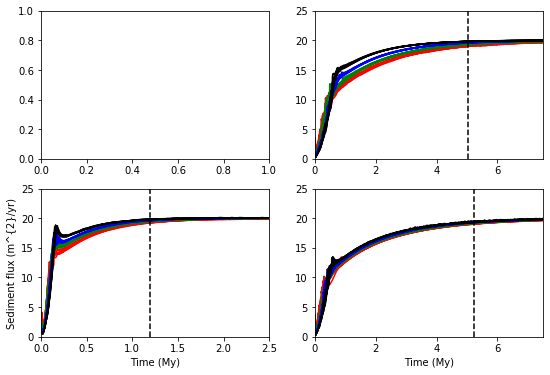

In [28]:
ly = bounds[3]
U = physical_space[4]
kappa = physical_space[0]

dtreal = 1e4*kappa/(ly*ly)

resolutions = [64, 128, 256, 512]
number = np.linspace(0, 9, 10)
colors = ['r', 'g', 'b', 'k']

plt.figure(figsize=(9, 6))
plt.subplot(221)

plt.subplot(222)
file = 'data/seds_SFDntn.txt'
var = warpSFDnodetonode
pltsed(file,var,7.5)

plt.subplot(223)
file = 'data/seds_MFDctc.txt'
var = warpMFDcelltocell
pltsed(file,var,2.5)
plt.ylabel('Sediment flux (m^{2}/yr)')
plt.xlabel('Time (My)')

plt.subplot(224)
file = 'data/seds_MFDntn.txt'
var = warpMFDnodetonode
pltsed(file,var,7.5)
plt.xlabel('Time (My)')

plt.show()

**Figure 7**: *Sediment flux that exits the model domain for (a) SFD cell-to-cell, (b) SFD node-to-node, (c) MFD cell-to-cell, (d) MFD node-to-node.*

To understand better how increasing resolution impacts the model evolution the total sediment flux eroded from the model domain is plotted against time, and the final valley spacing is calculated (Figure 7 and 8). To calculate the valley spacing I take horizontal swaths of the spatial distribution of water flux. For each swath profile a peak finding algorithm [Negri & Vestri](https://doi.org/10.5281/zenodo.887917) is used to find the distance from peak to peak in water flux. This distance is then averaged over the hundred swath profiles and over ten model runs to give the minimum, lower quartile, median, upper quartile, and maximum valley wavelength (Figure 8).

For the cell-to-cell SFD it can be seen that the evolution of the model is resolution dependent, as the wind-up time reduces as resolution is increased from 64 to 512 cells along the y-axis (Figure 7a). Furthermore, the mean valley spacing reduces with increasing resolution (Figure 8a). This behavior is not ideal, as it means that model behavior to perturbations in forcing might become resolution dependent. For the MFD cell-to-cell wind-up times remain resolution dependent, while the mean valley spacing is similar for the four different resolutions (Figure 7c and 8c).

In [29]:
def pltwav(file,ylimit):
    wave  = np.genfromtxt(file)
    ress  = wave[:,0]
    width = wave[:,2]

    wav64  = np.zeros(200)
    wav128 = np.zeros(200)
    wav256 = np.zeros(200)
    wav512 = np.zeros(200)

    i = 0
    j = 0
    k = 0
    l = 0
    m = 0
    for res in ress:
      if res == 64:
        wav64[i] = width[m]
        i += 1
      if res == 128:
        wav128[j] = width[m]
        j += 1
      if res == 256:
        wav256[k] = width[m]
        k += 1
      if res == 512:
        wav512[l] = width[m]
        l += 1
      m += 1

    x  = [64,128,256,512]
    y  = np.zeros(len(x))
    y_ = np.zeros(len(x))

    y[0] = np.mean(wav64)
    y[1] = np.mean(wav128)
    y[2] = np.mean(wav256)
    y[3] = np.mean(wav512)

    y_[0] = np.std(wav64)
    y_[1] = np.std(wav128)
    y_[2] = np.std(wav256)
    y_[3] = np.std(wav512)

    ys = [wav64,wav128,wav256,wav512]
    plt.boxplot(ys)
    plt.ylim((0,ylimit))
    plt.xticks([1, 2, 3, 4], ['64x256', '128x512', '256x1028', '512x2056'])

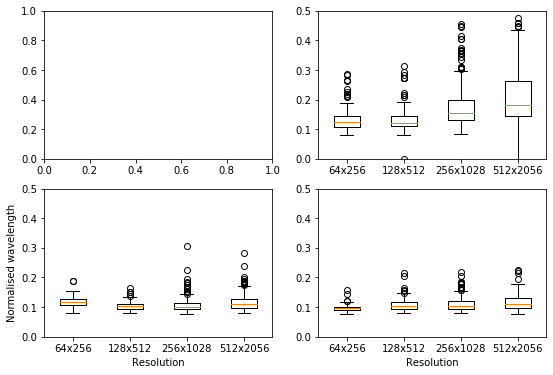

In [30]:
plt.figure(figsize=(9, 6))
plt.subplot(221)

plt.subplot(222)
file = 'data/wavs_SFDntn.txt'
pltwav(file,.5)

plt.subplot(223)
file = 'data/wavs_MFDctc.txt'
pltwav(file,.5)
plt.xlabel('Resolution')
plt.ylabel('Normalised wavelength')

plt.subplot(224)
file = 'data/wavs_MFDntn.txt'
pltwav(file,.5)
plt.xlabel('Resolution')

plt.show()

**Figure 8**: *Box wisker plots of the dimensionless valley-to-valley wavelength for each mode resolution: (a) SFD cell-to-cell, (b) SFD node-to-node, (c) MFD cell-to-cell, (d) MFD node-to-node.*

The node-to-node SFD algorithm is no better than the cell-to-cell SFD. In this case wind up time is resolution dependent, and the valley spacing increases with increasing resolution (Figure 7b and 8b). For the node-to-node SFD, at a resolution of 256 cells or less along the y-axis there is an instability in the sediment flux output. This is due to the flow tipping between adjacent nodes due to small differences in relative elevation after each time iteration. This unstable behavior disappears for the higher resolution of 512 cells along the y-axis (Figure 7b).

It is only when node-to-node MFD is used that the LEM becomes significantly less resolution dependent (Figure 7d and 8d). For the node-to-node MFD the time evolution of sediment flux is similar for all resolutions, and the valley spacing is similar as resolution is increased. The steady state sediment flux is however not completely stable (Figure 7d). This is due to the migration of the flow across the valley floors created within the model topography. Even once a balance has been achieved between erosion and uplift, small lateral changes in elevation can be seen to create a negative to positive change in elevation of a few meters between time iterations, where the time step is 100 yrs. This is associated with an equivalent change in water flux.

The model that has the least resolution dependence is the node-to-node MFD. The difference between this model and the other three is that this version has the maximum possible flow directions available within my set up. By treating flow paths as lines within the numerical grid, from any node there are 6 paths, which is twice as many as in the cell-to-cell MFD. This means that there is greater distribution of the flow, and a reduced localising of flow paths within the node-to-node distributed model. For SFD increasing resolution however leads to multiple branches.

The grid cells in the models presented are large. At the highest resolution, 2048 by 512 cells, the width of each triangle is of the order of 200 m if I was modelling a landscape 100 km wide. The model is therefore some approximation of local processes that give rise to the large scale landscape. By distributing flow in multiple directions the model is in a sense approximating for the hydrological processes that operate on a sub-grid scale that give rise to the river network. The assumption of SFD is however too strong, and the sub-grid scale processes are ignored.

The transport-limited model that I explore has certain limitations. In particular the valleys floors are wide and not representative of V-shaped valleys that would be expected from fluvial incision into bedrock (e.g. Figure 5). In order to generate such valleys a detachment-limited model, such as the stream power law, would be more appropriate. However, many stream power law models also suffer resolution dependence, as they typically use a SFD to route water (e.g. [Braun & Willett, 2013](https://doi.org/10.1016/j.geomorph.2012.10.008)). [Pelletier, 2010](#) looked at using MFD routing for the stream power law, and found that there remained some spatial resolution dependence. The model of \cite{pelletier-2010} used a rectangular grid and removed resolution issues by using a predictor-corrector algorithm to adjust for resolution effects. However, for the transport-limited model used here, I find that with a triangular grid the MFD routing is resolution independent without addition corrections. This is likely related to the fact that the length of each cell face is equal, while for rectangular cells the diagonal flow direction is longer than the cell faces. The implication is that for LEMs a mesh that has cells with node-to-node spacing of equal length is preferable to a rectangular grid, however this hypothesis will require further exploration.

## Conclusions

From this exploration of the various flow routing algorithms, it can be seen that for the two measures, convergence in wind-up time and valley-to-valley wavelength, a multiple flow direction (MFD) node-to-node routing algorithm is preferable.